<h1><center>Machine Learning Project - AVAZU<center></h1>


In [ ]:
import sys
from zipfile import ZipFile
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

AVAZU_URL = "https://bianchi.wp.imt.fr/files/2019/05/train-1000000.zip"
AVAZU_FILENAME = AVAZU_URL.rsplit('/', 1)[1]


if not op.exists(AVAZU_FILENAME):
    print('Downloading %s to %s...' % (AVAZU_URL, AVAZU_FILENAME))
    urlretrieve(AVAZU_URL, AVAZU_FILENAME)
    ZipFile(AVAZU_FILENAME).extractall('.')

In [ ]:
ZipFile(AVAZU_FILENAME).extractall('.')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

Data description here: https://www.kaggle.com/c/avazu-ctr-prediction/data  


**Exploratory Data Analysis (EDA):**

In [ ]:
df = pd.read_csv('train-1000000')

In [ ]:
df.head(100)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.740040e+19,1,14103004,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23804,320,50,2726,3,803,100053,229
96,1.538506e+19,0,14102119,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,21758,320,50,2502,0,35,-1,221
97,1.719816e+19,1,14102813,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,...,1,2,23454,320,50,2688,1,33,100176,212
98,1.376165e+19,0,14102109,1005,1,72a56356,45368af7,3e814130,ecad2386,7801e8d9,...,1,0,21665,320,50,2493,3,35,-1,117


In [ ]:
df.nunique()

id                  1000000
click                     2
hour                    240
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
dtype: int64

In [ ]:
df['click'].mean()

0.169971

we have an unbalaced data set, this mean that the accuracy is not a good performance measure. a better performance measure will be the AUR and the log loss.

Manipulating the hour column and generating 2 columns from the data in the "hour" column, weekday and hour:

In [ ]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)

    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])

    return datetime.datetime(year, month, day, hour)

# Example :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

In [ ]:
df['weekday'] = df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'] = df['hour'].apply(lambda x:datesplit(x).hour)

In [ ]:
df.nunique()

id                  1000000
click                     2
hour                     24
C1                        7
banner_pos                7
site_id                2651
site_domain            2871
site_category            22
app_id                 3157
app_domain              198
app_category             26
device_id            150501
device_ip            555248
device_model           5168
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     420
C18                       4
C19                      66
C20                     163
C21                      60
weekday                   7
dtype: int64

Dealing with rare features: Converting the features that appear less than 10 times to "rare features"

In [ ]:
df['C17'].value_counts()

1722    111327
2424     37931
2227     36296
1800     29272
423      23520
         ...  
2448         1
2465         1
2568         1
2084         1
2585         1
Name: C17, Length: 420, dtype: int64

In [ ]:
c17_counts = df['C17'].value_counts()

# Create a new column based on the condition
df['C17'] = df['C17'].apply(lambda x: x if c17_counts[x] >= 10 else -1)

In [ ]:
df['C17'].value_counts()

1722    111327
2424     37931
2227     36296
1800     29272
423      23520
         ...  
2218        13
1107        13
2270        12
2670        11
2206        10
Name: C17, Length: 397, dtype: int64

In [ ]:
df['C20'].value_counts()

-1         468959
 100084     60183
 100148     44519
 100111     41902
 100077     39088
            ...  
 100157         2
 100098         2
 100100         1
 100246         1
 100078         1
Name: C20, Length: 163, dtype: int64

In [ ]:
c20_counts = df['C20'].value_counts()

# Create a new column based on the condition
df['C20'] = df['C20'].apply(lambda x: x if c20_counts[x] >= 10 else -1)

In [ ]:
df['C20'].value_counts()

-1         468978
 100084     60183
 100148     44519
 100111     41902
 100077     39088
            ...  
 100169        18
 100122        18
 100153        16
 100024        16
 100137        13
Name: C20, Length: 155, dtype: int64

In [ ]:
df['site_id'].value_counts()

85f751fd    360911
1fbe01fe    159924
e151e245     65231
d9750ee7     24090
5b08c53b     22524
             ...  
6ddd2cf1         1
b8c50981         1
54ca087b         1
f25a9574         1
66095cf2         1
Name: site_id, Length: 2651, dtype: int64

In [ ]:
site_id_counts = df['site_id'].value_counts()

# Create a new column based on the condition
df['site_id'] = df['site_id'].apply(lambda x: x if site_id_counts[x] >= 10 else "rare")

In [ ]:
df['site_domain'].value_counts()

c4e18dd6    374158
f3845767    159924
7e091613     82263
7687a86e     31858
98572c79     24879
             ...  
a6bffa37         1
cd328739         1
b87a3d65         1
8df32dac         1
62ff8594         1
Name: site_domain, Length: 2871, dtype: int64

In [ ]:
site_domain_counts = df['site_domain'].value_counts()

# Create a new column based on the condition
df['site_domain'] = df['site_domain'].apply(lambda x: x if site_domain_counts[x] >= 10 else "rare")

In [ ]:
df['app_id'].value_counts()

ecad2386    639089
92f5800b     38643
e2fcccd2     28008
9c13b419     18820
febd1138     18726
             ...  
2c3336ca         1
ee3d199e         1
276d6d97         1
b8171d73         1
1017e2d5         1
Name: app_id, Length: 3157, dtype: int64

In [ ]:
app_id_counts = df['app_id'].value_counts()

# Create a new column based on the condition
df['app_id'] = df['app_id'].apply(lambda x: x if app_id_counts[x] >= 10 else "rare")

In [ ]:
df['app_domain'].value_counts()

7801e8d9    673864
2347f47a    129388
ae637522     46638
5c5a694b     28019
82e27996     18727
             ...  
26894d3c         1
bb27eb10         1
6f406d5b         1
1d1d4953         1
a5ab1a9f         1
Name: app_domain, Length: 198, dtype: int64

In [ ]:
app_domain_counts = df['app_domain'].value_counts()

# Create a new column based on the condition
df['app_domain'] = df['app_domain'].apply(lambda x: x if app_domain_counts[x] >= 10 else "rare")

In [ ]:
df['app_category'].value_counts()

07d7df22    647297
0f2161f8    236433
cef3e649     42612
8ded1f7a     36310
f95efa07     28298
d1327cf5      3106
09481d60      1403
dc97ec06      1358
75d80bbe      1003
fc6fa53d       597
4ce2e9fc       495
879c24eb       311
a3c42688       271
4681bb9d       159
0f9a328c       123
2281a340        69
a86a3e89        69
8df2e842        40
79f0b860         9
0bfbc358         9
7113d72a         7
18b1e0be         7
2fc4f2aa         7
a7fd01ec         5
86c1a5a3         1
5326cf99         1
Name: app_category, dtype: int64

In [ ]:
app_category_counts = df['app_category'].value_counts()

# Create a new column based on the condition
df['app_category'] = df['app_category'].apply(lambda x: x if app_category_counts[x] >= 10 else "rare")

In [ ]:
df['device_ip'].value_counts()

6b9769f2    5130
431b3174    3291
2f323f36    2197
930ec31d    2196
285aa37d    2181
            ... 
9a34079d       1
d78c2be9       1
68b28485       1
ea9c002b       1
3ca7f719       1
Name: device_ip, Length: 555248, dtype: int64

In [ ]:
device_ip_counts = df['device_ip'].value_counts()

# Create a new column based on the condition
df['device_ip'] = df['device_ip'].apply(lambda x: x if device_ip_counts[x] >= 10 else "rare")

In [ ]:
df['device_ip'].value_counts()

rare        748728
6b9769f2      5130
431b3174      3291
2f323f36      2197
930ec31d      2196
             ...  
805f352e        10
6b9d06a1        10
7061c36a        10
ee300829        10
4ae93406        10
Name: device_ip, Length: 8853, dtype: int64

In [ ]:
df['device_id'].value_counts()

a99f214a    824918
0f7c61dc       512
c357dbff       481
936e92fb       366
afeffc18       242
             ...  
98fcb9ef         1
ceb4ddfc         1
0eabc47f         1
4c6417bb         1
aab31253         1
Name: device_id, Length: 150501, dtype: int64

In [ ]:
device_id_counts = df['device_id'].value_counts()

# Create a new column based on the condition
df['device_id'] = df['device_id'].apply(lambda x: x if device_id_counts[x] >= 10 else "rare")

In [ ]:
df['device_model'].value_counts()

8a4875bd    60790
1f0bc64f    35103
d787e91b    34780
76dc4769    18663
be6db1d7    18357
            ...  
0bbd5ecd        1
4b0d3c7e        1
52b9ae0f        1
e207ef57        1
78cd4bd4        1
Name: device_model, Length: 5168, dtype: int64

In [ ]:
device_model_counts = df['device_model'].value_counts()

# Create a new column based on the condition
df['device_model'] = df['device_model'].apply(lambda x: x if device_model_counts[x] >= 10 else "rare")

Plotting the mean of clicks per hour in the day and day of the week:

<ipython-input-34-51190b6a5742>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('hour').mean()['click'].plot()


<Axes: xlabel='hour'>

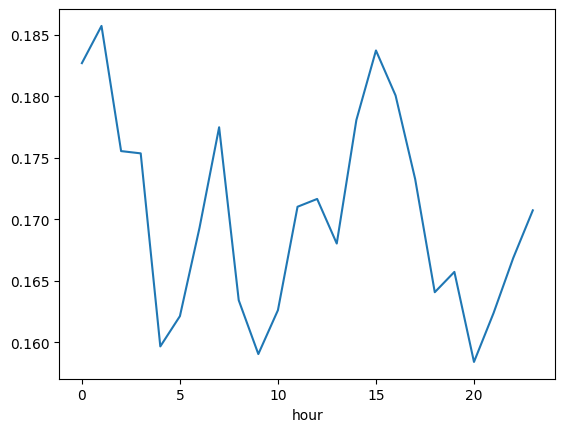

In [ ]:
df.groupby('hour').mean()['click'].plot()

<ipython-input-35-61f3dddc66c2>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('weekday').mean()['click'].plot()


<Axes: xlabel='weekday'>

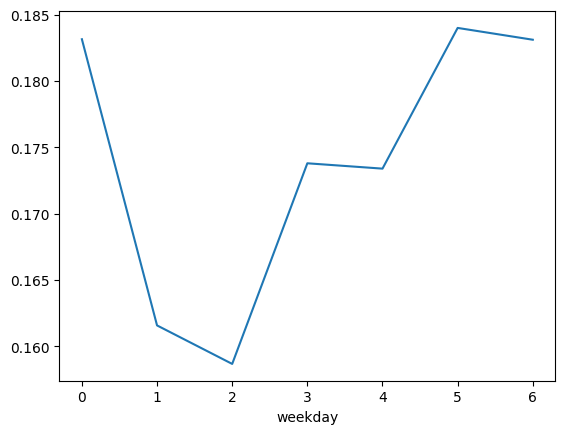

In [ ]:
df.groupby('weekday').mean()['click'].plot()

We can see some correlation between the hour of the day and the average click rate. also we can see that the average click rate is higher on the weekends than during the week.

<ipython-input-36-a3d5e383da4b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('banner_pos').mean()['click'].plot()


<Axes: xlabel='banner_pos'>

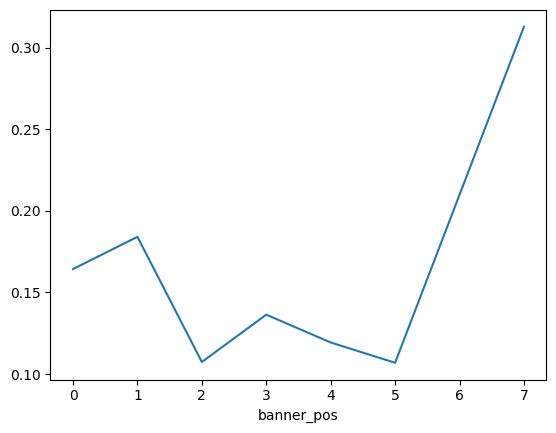

In [ ]:
df.groupby('banner_pos').mean()['click'].plot()

We can see from the graph above that the banner possition might have a certain correlation with the average click rate.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 25 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1000000 non-null  float64
 1   click             1000000 non-null  int64  
 2   hour              1000000 non-null  int64  
 3   C1                1000000 non-null  int64  
 4   banner_pos        1000000 non-null  int64  
 5   site_id           1000000 non-null  object 
 6   site_domain       1000000 non-null  object 
 7   site_category     1000000 non-null  object 
 8   app_id            1000000 non-null  object 
 9   app_domain        1000000 non-null  object 
 10  app_category      1000000 non-null  object 
 11  device_id         1000000 non-null  object 
 12  device_ip         1000000 non-null  object 
 13  device_model      1000000 non-null  object 
 14  device_type       1000000 non-null  int64  
 15  device_conn_type  1000000 non-null  int64  
 16  C

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['click'],axis = 1), df['click'], test_size=0.1, random_state=100)

**Starting With a simple Logistic regression:**

<ipython-input-39-9ae4107868e0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df[['click','hour','weekday','C1', 'banner_pos', 'site_category','app_category', 'device_type', 'device_conn_type', "C15", 'C16', 'C18','C21']].corr(),annot=True)


<Axes: >

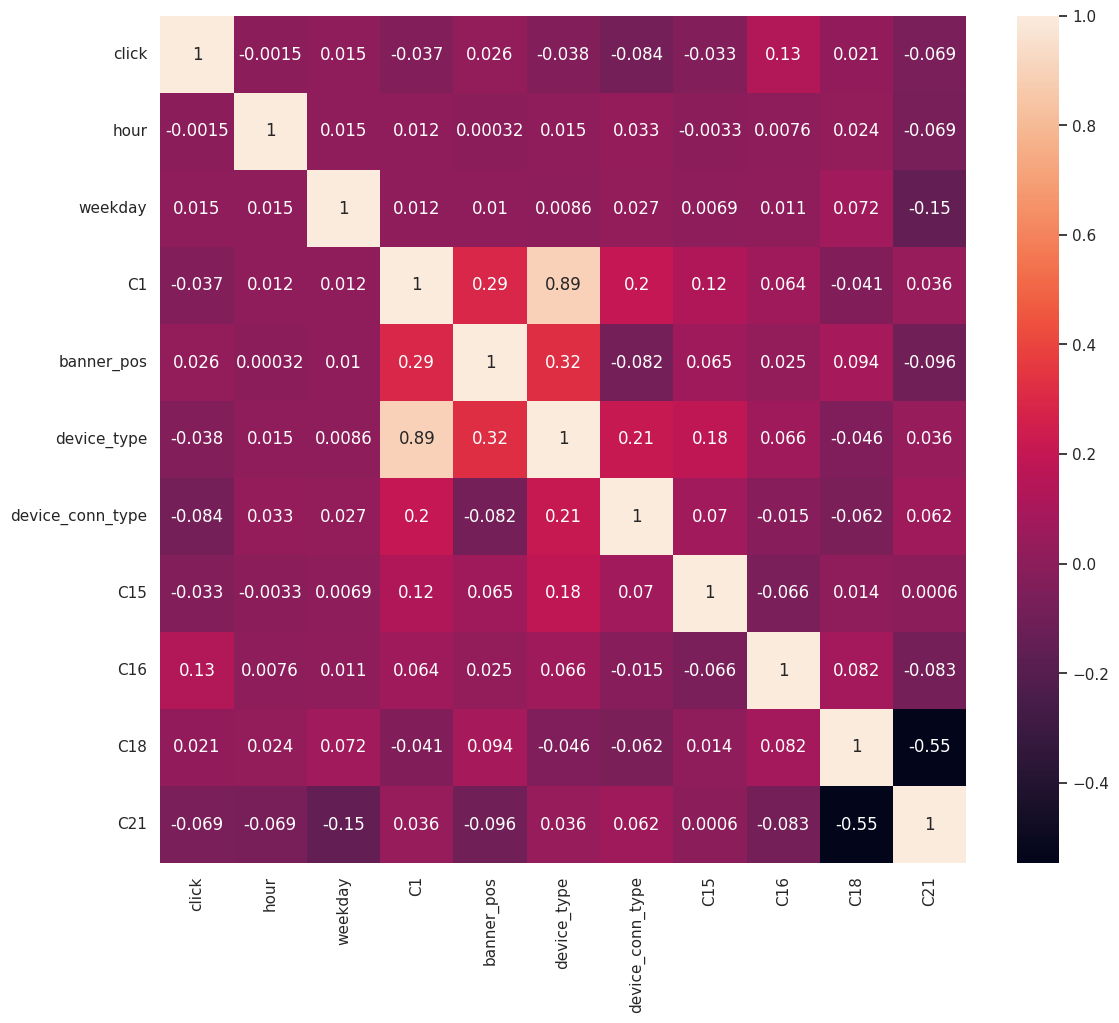

In [ ]:
sns.set(rc = {'figure.figsize':(13,11)})
sns.heatmap(df[['click','hour','weekday','C1', 'banner_pos', 'site_category','app_category', 'device_type', 'device_conn_type', "C15", 'C16', 'C18','C21']].corr(),annot=True)

In [ ]:
some_columns = ['hour','weekday','C1', 'banner_pos', 'site_category','app_category', 'device_type', 'device_conn_type', "C15", 'C16', 'C18','C21']

In [ ]:
#Onehotencoding for categorial columns:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown= 'ignore')
ohe.fit(X_train[some_columns])
X_train_oh = ohe.transform(X_train[some_columns])
X_test_oh = ohe.transform(X_test[some_columns])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss

lgr = LogisticRegression()
lgr.fit(X_train_oh,y_train)
y_pred = lgr.predict_proba(X_test_oh)

#calculating the AUC:
auc = roc_auc_score(y_test, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test, y_pred[:,1])
print("Log Loss:", logloss)

AUC: 0.6761800445026527
Log Loss: 0.42516134703019043


C:\Users\hendb\anaconda3_23\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


the simple logistic regretions doesn't achieve good results, the AUC is low and the log loss is high.

Since or data set is not ballanced, meaning we have way more zeros (not clicked) in the llabels than 1 (clicked) we try to set class_weight hyperparameter to balanced:

In [ ]:
lgr = LogisticRegression(class_weight = 'balanced')
lgr.fit(X_train_oh,y_train)
y_pred = lgr.predict_proba(X_test_oh)

#calculating the AUR:
auc = roc_auc_score(y_test, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test, y_pred[:,1])
print("Log Loss:", logloss)

AUC: 0.6761021013022085
Log Loss: 0.6408352442583208


C:\Users\hendb\anaconda3_23\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We still don't achieve better results.

**Reducing the dimention of the data using the hashing trick:**

In [ ]:
def hash_func(col,hash_size = 100):
    hashed_col = hash(col) % hash_size
    return hashed_col


In [ ]:
df.nunique()

id                  1000000
click                     2
hour                     24
C1                        7
banner_pos                7
site_id                1182
site_domain             974
site_category            22
app_id                  923
app_domain               70
app_category             19
device_id               158
device_ip              8853
device_model           2689
device_type               5
device_conn_type          4
C14                    2243
C15                       8
C16                       9
C17                     397
C18                       4
C19                      66
C20                     155
C21                      60
weekday                   7
dtype: int64

In [ ]:
#define columns that have more than 100 values to hash
hashing_cols = ['C14','C17','C20','site_id','site_domain','app_id','device_ip','device_model']

for col in hashing_cols:
  hashed = df[col].apply(hash_func)
  df[col] = hashed


In [ ]:
X_train_hashed, X_test_hashed, y_train_hashed, y_test_hashed = train_test_split(df.drop(['click'],axis = 1), df['click'], test_size=0.1, random_state=100)

Running Logistic regretion with the reduced dimention data:

In [ ]:
ohe = OneHotEncoder(handle_unknown= 'ignore')
ohe.fit(X_train_hashed[some_columns])
X_train_oh = ohe.transform(X_train_hashed[some_columns])
X_test_oh = ohe.transform(X_test_hashed[some_columns])

In [ ]:
lgr = LogisticRegression()
lgr.fit(X_train_oh,y_train_hashed)
y_pred = lgr.predict_proba(X_test_oh)

#calculating the AUR:
auc = roc_auc_score(y_test_hashed, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test_hashed, y_pred[:,1])
print("Log Loss:", logloss)

AUC: 0.6761800445026527
Log Loss: 0.42516134703019043


C:\Users\hendb\anaconda3_23\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


After Hashing some of the columns we can observe a reduction in the log loss but the AUC is still high.

**Next Step:**
Increase the number of columns that we are using:
We first plot the heat map of the features and try to choose the columns that are most correlated with 'click'

C:\Users\hendb\AppData\Local\Temp\ipykernel_34572\1679877444.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,fmt=".3f")


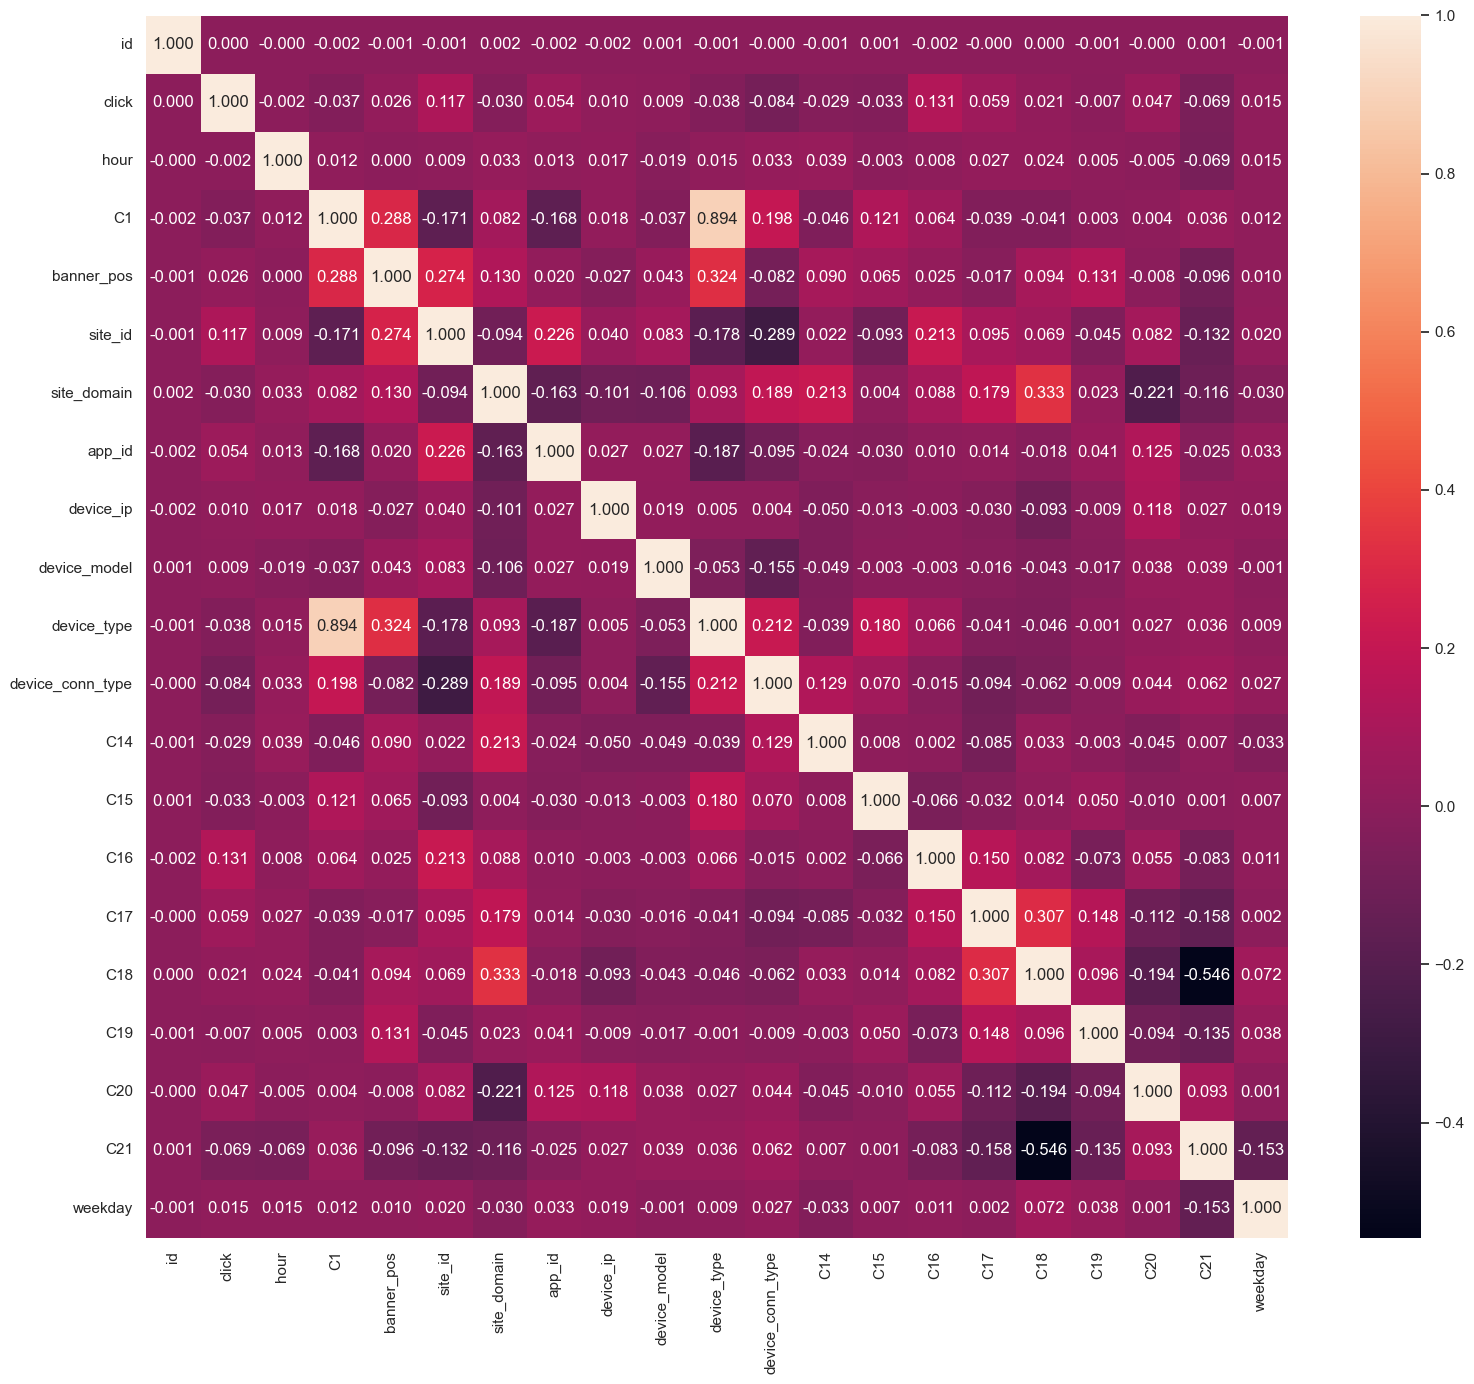

In [ ]:
sns.set(rc = {'figure.figsize':(16,14)})
sns.heatmap(df.corr(),annot=True,fmt=".3f")


# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_1 = df.drop(['id','click'],axis = 1)

In [ ]:
ohe = OneHotEncoder(handle_unknown= 'ignore')
ohe.fit(X_train_hashed[df_1.columns.tolist()])
X_train_oh = ohe.transform(X_train_hashed[df_1.columns.tolist()])
X_test_oh = ohe.transform(X_test_hashed[df_1.columns.tolist()])

In [ ]:
lgr = LogisticRegression()
lgr.fit(X_train_oh,y_train_hashed)
y_pred = lgr.predict_proba(X_test_oh)

#calculating the AUR:
auc = roc_auc_score(y_test_hashed, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test_hashed, y_pred[:,1])
print("Log Loss:", logloss)

AUC: 0.7293358494424327
Log Loss: 0.40633472984557784


C:\Users\hendb\anaconda3_23\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We can see that after using the hashing trick and using more columns our logistic regression model was able to achieve higher AUC and lower log loss.

In [ ]:
#Compare to Logistic regression with more columns but without hashing:
ohe = OneHotEncoder(handle_unknown= 'ignore')
ohe.fit(X_train[df_1.columns.tolist()])
X_train_oh_1 = ohe.transform(X_train[df_1.columns.tolist()])
X_test_oh_1 = ohe.transform(X_test[df_1.columns.tolist()])

In [ ]:
lgr = LogisticRegression()
lgr.fit(X_train_oh_1,y_train)
y_pred = lgr.predict_proba(X_test_oh_1)

#calculating the AUC:
auc = roc_auc_score(y_test, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test, y_pred[:,1])
print("Log Loss:", logloss)

AUC: 0.7447923614095956
Log Loss: 0.3990477205307003


C:\Users\hendb\anaconda3_23\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We achieved better AUC score and better log loss score when using logistic regression with more columns but without hashing. this can be due information loss when we hashed our data.

**Use Decision Tree to predict:**

In [ ]:
#we firstly use dicision tree model with the default parameters:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train_oh,y_train_hashed)

y_pred = dtc.predict_proba(X_test_oh)

#calculating the AUR:
auc = roc_auc_score(y_test_hashed, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test_hashed, y_pred[:,1])
print("Log Loss:", logloss)

AUC: 0.5781672091016063
Log Loss: 6.983990021426927


using simple decision tree model gives bad results, we get an AUC of 0.57 which means our model is as good as a random predictor, and our log loss is bad.
to try and make our results better we use random forest next which might imcrease the accuracy and reduce the overfitting that the decision tree model tends to have.

**Using Random Forest:**

In [ ]:
#using random forest with the default values (on non hashed data)
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_oh_1,y_train_hashed)

y_pred = rfc.predict_proba(X_test_oh_1)

#calculating the AUR:
auc = roc_auc_score(y_test, y_pred[:,1])
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test, y_pred[:,1])
print("Log Loss:", logloss)


AUC: 0.7028955177878963
Log Loss: 0.6247936487821485


We can see that random forest with the default parameters did achive better results than the desicion tree but we still have a high log loss and the computational time it took was too long.

**Using XGboost model:**

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

In [ ]:
n_components = 50

# Create a TruncatedSVD model
svd = TruncatedSVD(n_components=n_components)

# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Create a pipeline with TruncatedSVD and XGBoost
pipeline = Pipeline([
    ('svd', svd),
    ('xgb', xgb_model)
])

# Define the hyperparameter grid to search
param_grid = {
    'svd__n_components': [50, 100],
    'xgb__learning_rate': [0.05,0.1, 0.2],
    'xgb__max_depth': [5, 7],
    'xgb__n_estimators': [200, 300],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0],
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2)

# Fit the model on the training data
grid_search.fit(X_train_oh, y_train_hashed)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

#make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_oh)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  59.9s
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time= 1.1min
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=0.8; total time=  59.5s
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=  55.7s
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=  59.6s
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200,

[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=  31.7s
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=  58.5s
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.4min
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time= 1.5min
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time= 1.4min
[CV] END svd__n_components=50, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time= 1.3min
[CV] END svd__n_components=5

[CV] END svd__n_components=50, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time= 1.1min
[CV] END svd__n_components=50, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time= 1.3min
[CV] END svd__n_components=50, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=0.8; total time= 1.2min
[CV] END svd__n_components=50, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=  48.5s
[CV] END svd__n_components=50, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time=  54.2s
[CV] END svd__n_components=50, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time= 1.4min
[CV] END svd__n_components=5

[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time= 1.4min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time= 1.6min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=300, xgb__subsample=1.0; total time= 1.9min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time= 1.9min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time= 1.9min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time= 2.1min
[CV] END svd__n_

[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time= 1.9min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time= 1.8min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=0.8; total time= 1.6min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.6min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.5min
[CV] END svd__n_components=100, xgb__colsample_bytree=0.8, xgb__learning_rate=0.2, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.6min
[CV] END svd__n_compon

[CV] END svd__n_components=100, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.7min
[CV] END svd__n_components=100, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.6min
[CV] END svd__n_components=100, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=200, xgb__subsample=1.0; total time= 1.4min
[CV] END svd__n_components=100, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time= 2.0min
[CV] END svd__n_components=100, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time= 2.1min
[CV] END svd__n_components=100, xgb__colsample_bytree=1.0, xgb__learning_rate=0.1, xgb__max_depth=7, xgb__n_estimators=300, xgb__subsample=0.8; total time= 2.1min
[CV] END svd__n_compon

In [ ]:
y_pred.shape

(100000,)

In [ ]:
#calculating the AUR:
auc = roc_auc_score(y_test_hashed, y_pred)
print("AUC:", auc)

#calculating the log loss:
logloss = log_loss(y_test_hashed, y_pred)
print("Log Loss:", logloss)

AUC: 0.524080883902015
Log Loss: 6.010639639169176


Above we used the XGboost model after using SVD to lower the dimention of the data. we used Gridsearch to find the best parameters for XGboost and for SVD.
I would have expected the XGboost to give better results than the other models we used specifically the other desicion tree models since it reduces over fitting and supposedly deals better with unbalanced data sets (like the one we have here).
but we got an AUC score of 0.52 meaning our model isn't better than a random predictor model and the log loss is high.
maybe if we try to use XGboost on the non-hashed data we would get better results.

Conlusion:
the best score we got so far was the Logistic regression without hashing.

##Work assignment

1.   Perform Exploratory Data Analysis (EDA)
2.   Predict the probability that an add is clicked, based on the features.
3.   Evaluate the performance of your method.

##Work evaluation

Your work will be evaluated based on:

*   The interest of the EDA (4 points)
*   The quality of the comments/remarks throughout the notebook (4 points)
*   The feature engineering (5 points)
*   The efforts made in trying several predictors and tuning them (5 points)
*   The relevance of the performance criteria used to conclude (2 points)
*   BONUS (+1pt) : Register to the AVAZU challenge in Kaggle. What is your rank?

You may find the following script useful to convert the raw time stamp into a more useable feature. For instance, you may generate new pandas series using the code:

```
df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'].apply(lambda x:datesplit(x).hour)
```



In [ ]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)

    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])

    return datetime.datetime(year, month, day, hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)